# Time Series Aanalysis

En este Notebook haremos uso de la libreria prophet de Facebook para predecir el precio del bitcoin en base al sentimiento en twitter en ese instante.

## Imports

In [36]:
import pandas as pd
import numpy as np
import itertools

from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.plot import plot_plotly, plot_components_plotly
import plotly.graph_objs as go

from JABA.service.scrapper import DFPicker

from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric

import json
from prophet.serialize import model_to_json, model_from_json

## Prophet

### Pick the data

En primer lugar establecemos las fechas de inicio y fin de los datos, que por una parte se usaran para entrenar el modelo, y por otra, para establecer las fechas de las que se quiere realizar la predeccion.
Para todo esto es **necesario tener en la carpeta de data los valores de bitcoin y el sentimiento de twitter**.
Haremos uso de la funcion **get_complete_df(dateFrom, dateTo)** de **DFPicker** para recopilar los datos de las fechas de las que queremos realizar la observacion:

In [37]:
date_init = "2014-01-01"
date_limit = "2021-06-10"
date_init_predict = "2021-06-11"
date_limit_predict = "2021-06-17"

In [38]:
def get_fit_predict_data(date_init, date_limit, date_init_predict, date_limit_predict):
    
    # Data for fitting the model
    fit_df = DFPicker.get_complete_df(date_init, date_limit)
    data = { 'ds': fit_df.index.values,
             'y': fit_df.Close,
             'sentiment_v': fit_df.sentiment_v,
             'sentiment_v2': fit_df.sentiment_v2
           }
    prophet_fit_df = pd.DataFrame(data, columns=['ds', 'y', 'sentiment_v', 'sentiment_v2'])
    prophet_fit_df.reset_index(drop=True, inplace=True)
    prophet_fit_df['y'] = prophet_fit_df['y'].shift(periods = 36)
    #prophet_fit_df['sentiment_v2'] = prophet_fit_df['sentiment_v2'].shift(periods = 36)
    for i in range(0,36):
        prophet_fit_df.drop(index=i, inplace=True)
    
    # Data for the prediction (sentiment and dates)
    future_data = DFPicker.get_complete_df(date_init_predict, date_limit_predict)
    future_data['date'] = future_data.index.values
    future_data['date'] = future_data['date'].dt.date
    grouped_data = future_data.groupby(['date']).agg({'sentiment_v' : 'mean' , 'sentiment_v2' : 'mean', 'Datetime':'count'})

    future_df = pd.concat([fit_df, grouped_data], ignore_index=False)
    future_df['ds'] = future_df.index.values
    future_df.Close.rename('y')
    print(future_df)
    
    return prophet_fit_df, future_df, future_data
    

Recojemos los datos referentes a las fechas establecidas anteriormente.

In [39]:
prophet_fit_df, future_df, future_data = get_fit_predict_data(date_init, date_limit, date_init_predict, date_limit_predict)

Current Date 2014-01-01
Current Date 2015-01-01
Current Date 2016-01-01
Current Date 2017-01-01
Current Date 2018-01-01
Current Date 2019-01-01
Current Date 2020-01-01
Current Date 2021-01-01
Current Date 2014-01-01
Current Date 2015-01-01
Current Date 2016-01-01
Current Date 2017-01-01
Current Date 2018-01-01
Current Date 2019-01-01
Current Date 2020-01-01
Current Date 2021-01-01
Extraction Completed!
Extraction Completed!
                     sentiment_v  Datetime  sentiment_v2       Close  \
2014-01-01 00:00:00    42.848586       158     37.969439  734.104333   
2014-01-01 00:30:00    28.873142       132     25.022919  737.149667   
2014-01-01 01:00:00    31.421786       140     22.280429  738.848000   
2014-01-01 01:30:00    20.206449       105     15.187558  739.230000   
2014-01-01 02:00:00    23.173371       103     18.362825  747.851333   
...                          ...       ...           ...         ...   
2021-06-12            622.553142        48    545.567656         NaN

### Model Evaluation

Definimos una funcion para comprobar si la prediccion del modelo es correcta

In [40]:
def model_score_lower_upper(forecast, real_data, upper_value):
    score = 0

    real_data = real_data.groupby(['date']).agg({'Close' : 'mean'})
    for prediction in forecast.values:
        i=1
        if(prediction[2] < real_data.iloc[i].Close):
            score += 1- upper_value
        if(prediction[3] > real_data.iloc[i].Close):
            score += upper_value
        i += 1
    score = score / forecast.shape[0]
    return score
    

In [41]:
model = Prophet(changepoint_prior_scale=0.5, seasonality_prior_scale=1.0)
model.add_regressor('sentiment_v')
model.add_regressor('sentiment_v2')
model.fit(prophet_fit_df)

forecast = model.predict(future_df)

In [42]:
score_upper_lower = model_score_lower_upper(forecast, future_data, 0.1)
score_lower = model_score_lower_upper(forecast, future_data, 0)
print("La puntuacion del modelo teniendo en cuenta el Upper y el Lower es de = ", score_upper_lower)
print("La puntuacion del modelo teniendo en el Lower es de = ", score_lower)
print("Estas son las predicciones realizadas por el modelo:")
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(120))


La puntuacion del modelo teniendo en cuenta el Upper y el Lower es de =  0.8631269256594746
La puntuacion del modelo teniendo en el Lower es de =  0.9521470876672767
Estas son las predicciones realizadas por el modelo:
                        ds          yhat    yhat_lower    yhat_upper
129381 2021-06-07 15:00:00  45095.446688  41256.972796  48368.611519
129382 2021-06-07 15:30:00  46850.370130  43133.618278  50658.557424
129383 2021-06-07 16:00:00  44358.955407  40419.461677  47692.396559
129384 2021-06-07 16:30:00  44186.510626  40414.624088  48146.597239
129385 2021-06-07 17:00:00  44367.703876  40365.418672  48268.807742
...                    ...           ...           ...           ...
129496 2021-06-12 00:00:00  43733.736578  39754.328220  47151.826352
129497 2021-06-13 00:00:00  45434.321986  41854.244040  49148.711584
129498 2021-06-14 00:00:00  45027.312292  41359.133441  49091.609848
129499 2021-06-15 00:00:00  44504.093307  40582.127979  48410.947789
129500 2021-06-16 00:0

### Plotting the results

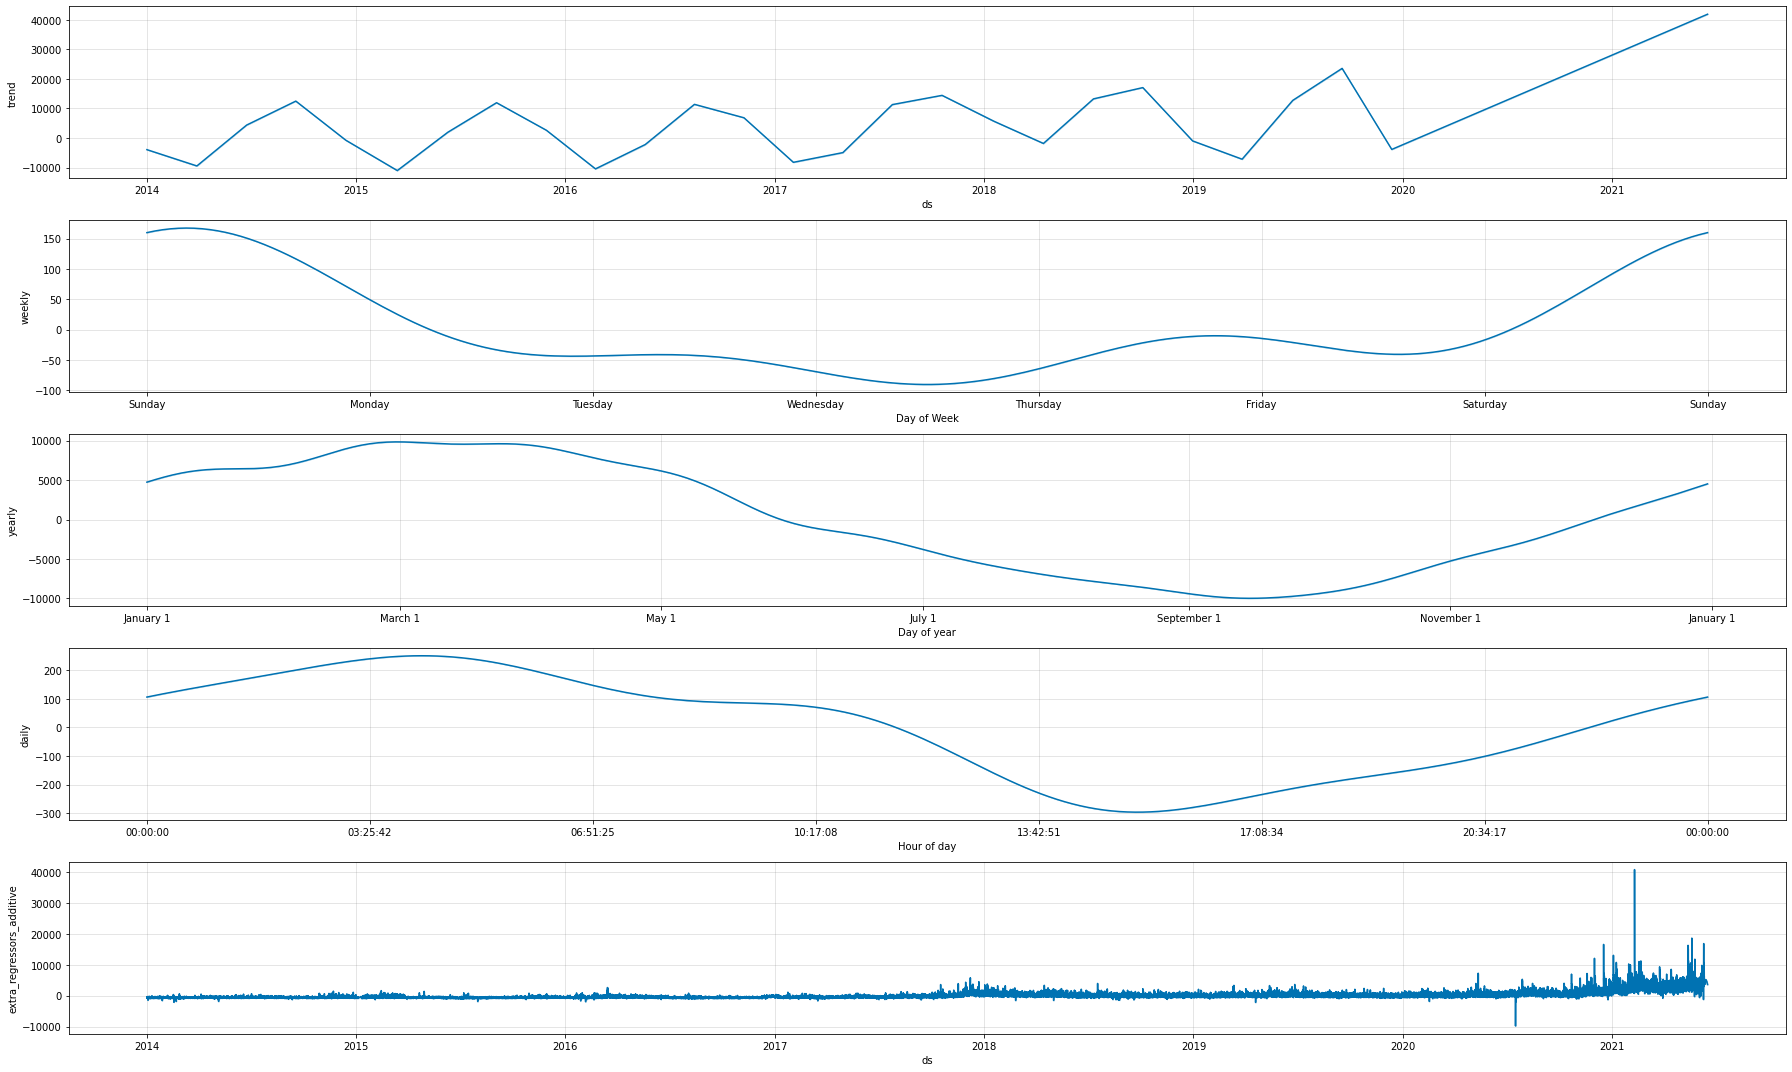

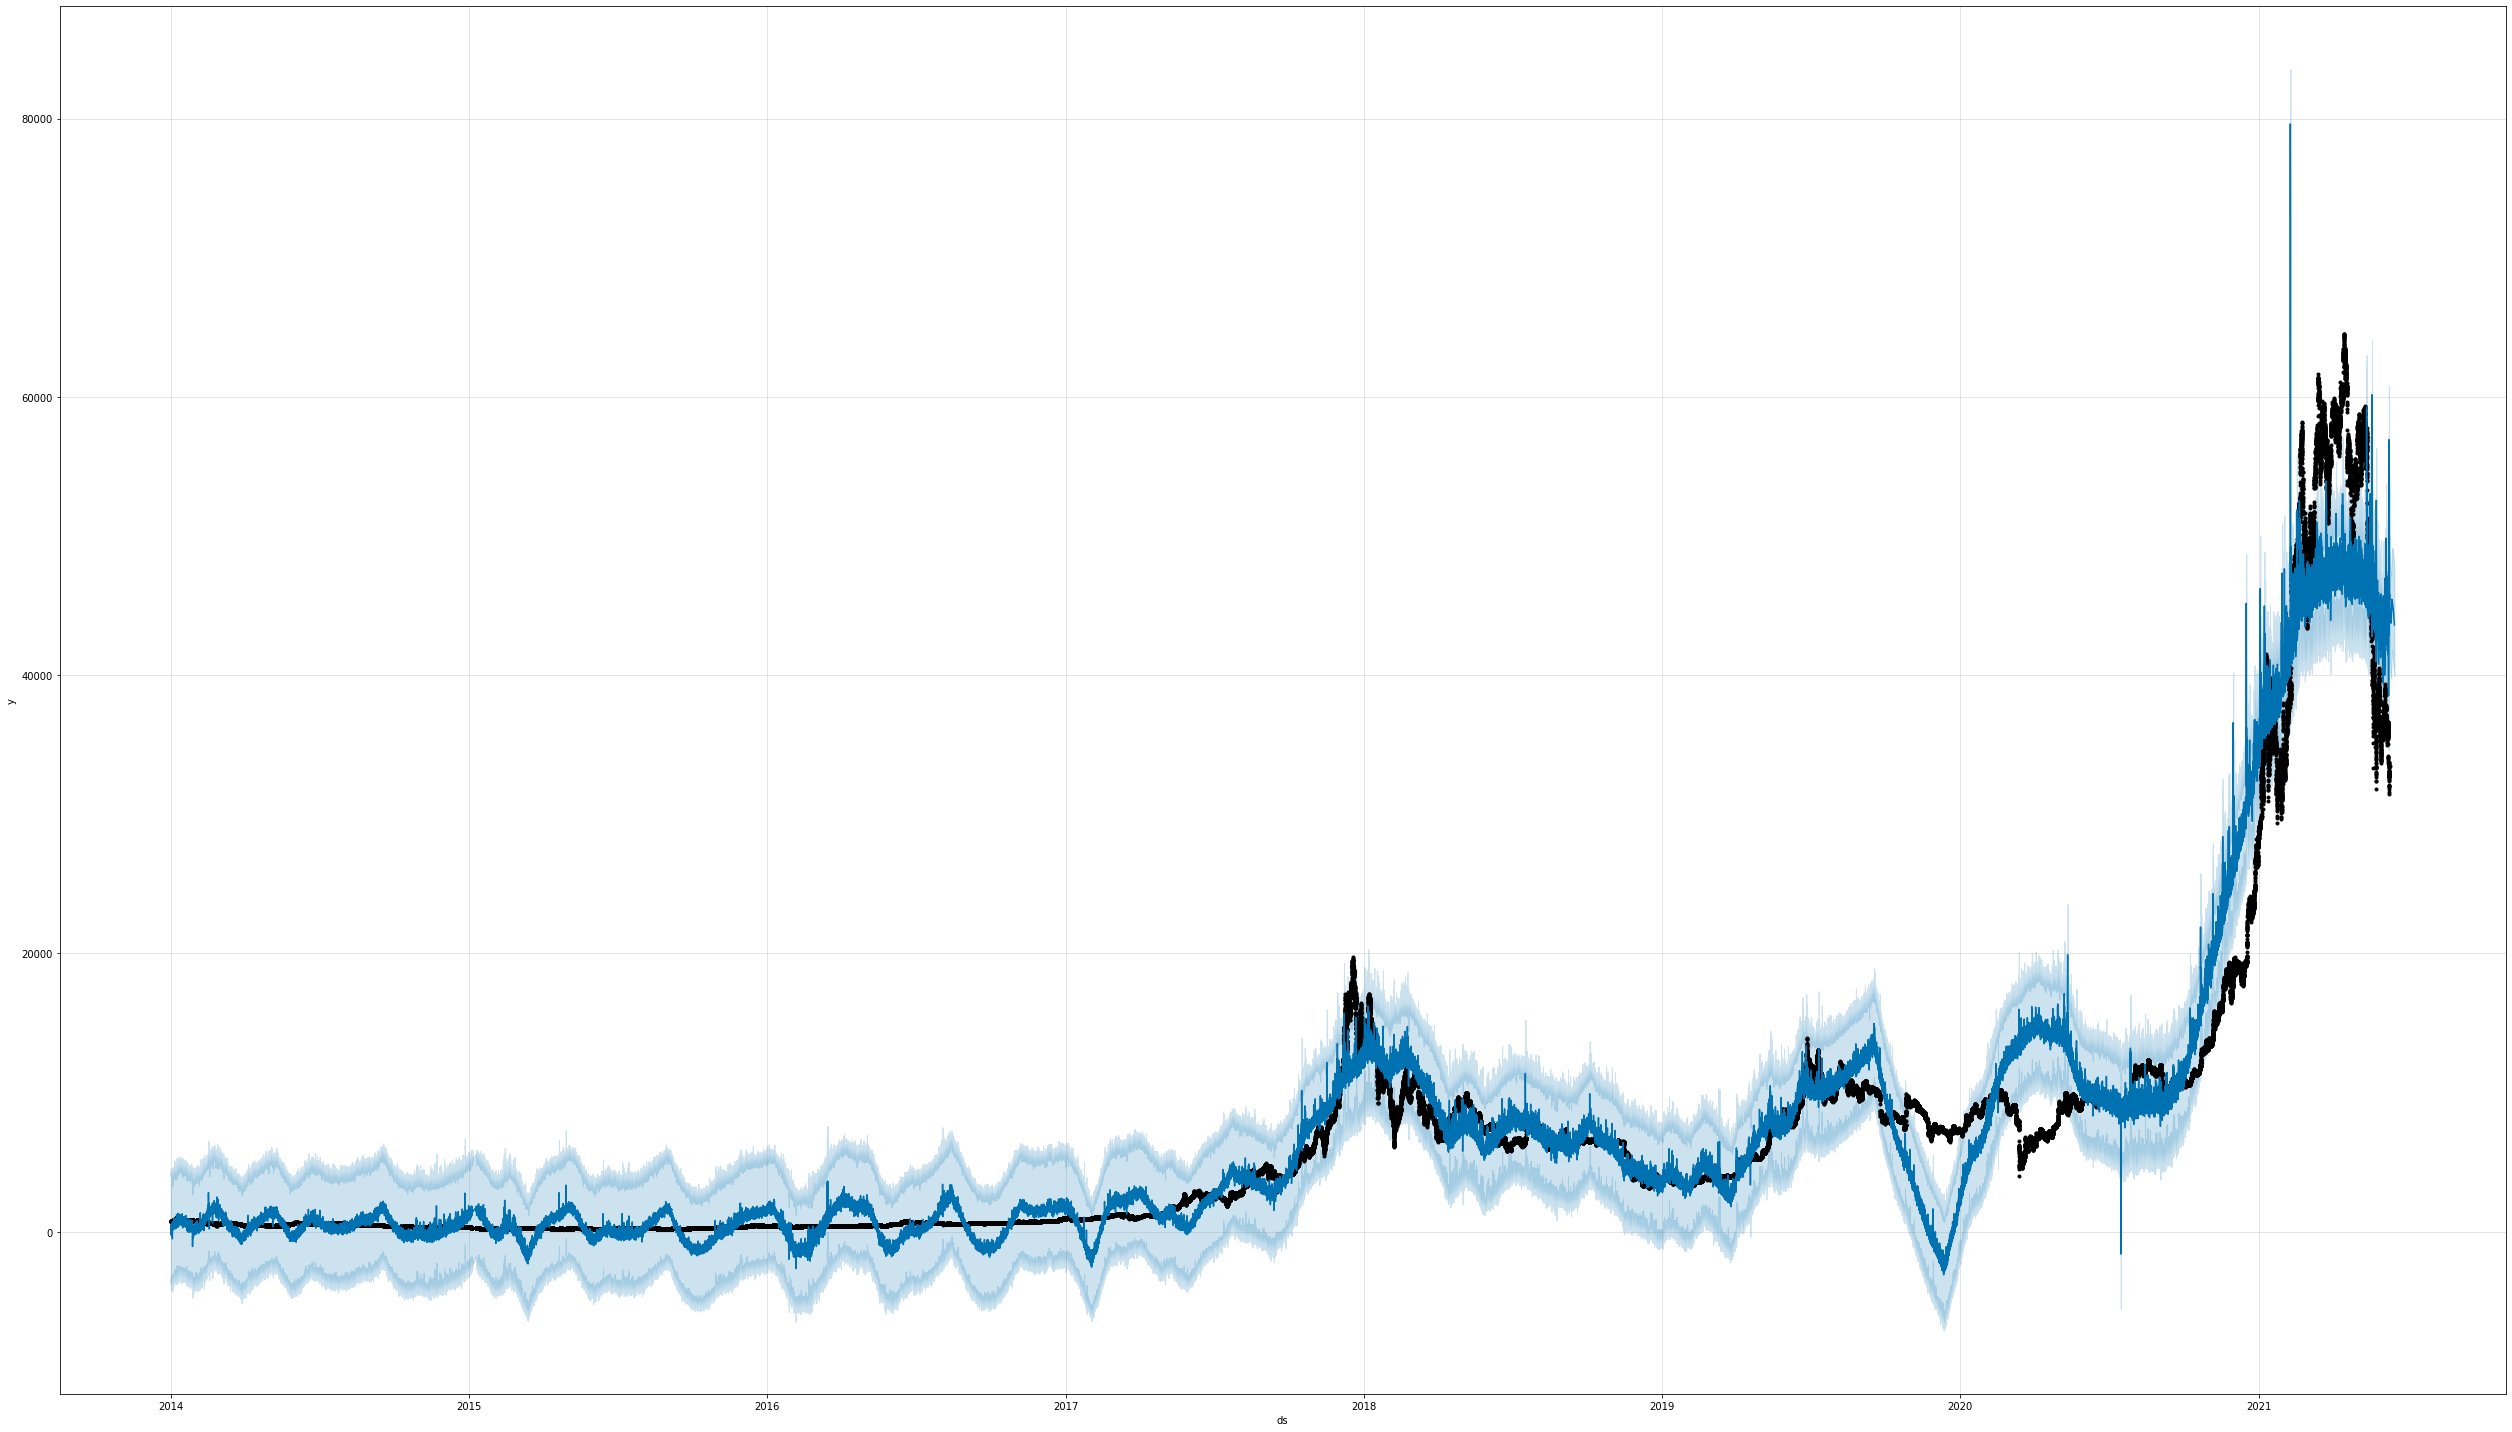

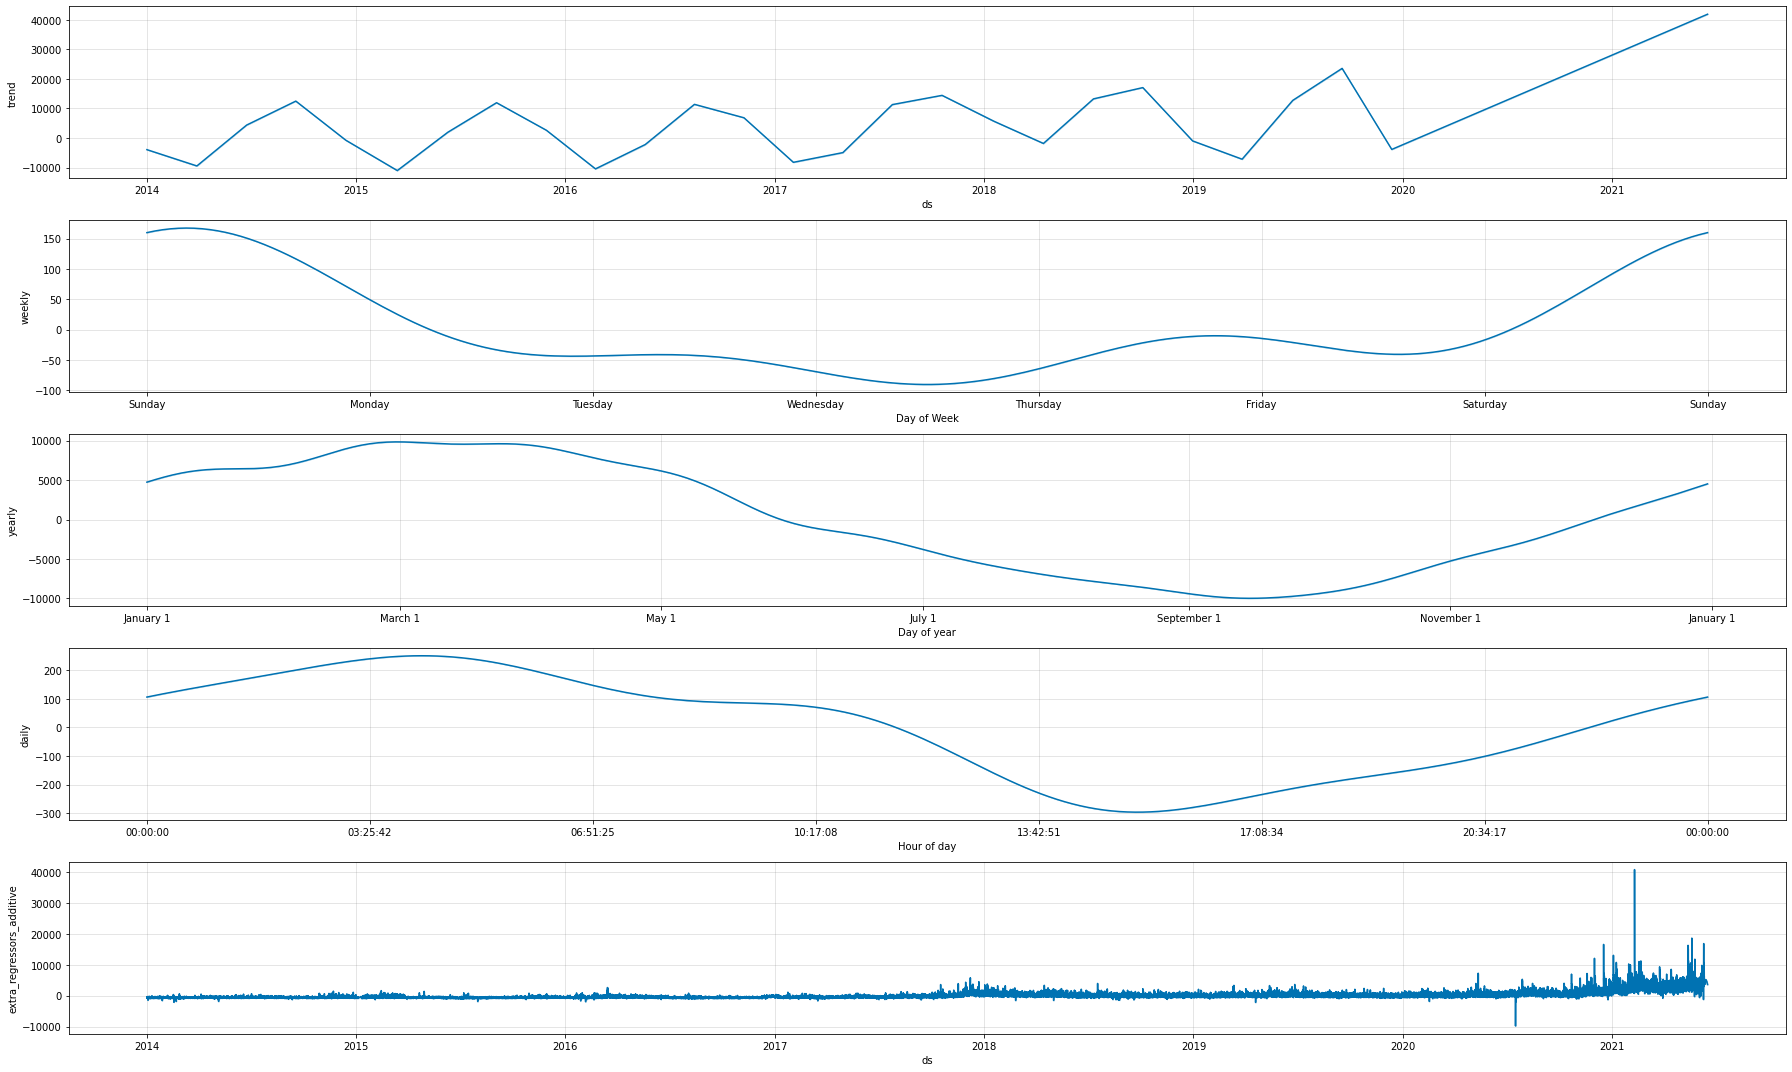

In [43]:
model.plot(forecast, figsize=(35, 20))
model.plot_components(forecast, figsize=(25, 15))

### Save the model

Podemos guardar nuestro modelo entrenado para poder hacer uso de el en un futuro.

In [44]:
with open('serialized_model.json', 'w') as fout:
    json.dump(model_to_json(model), fout) 

### Load the model

Podemos cargar el modelo guardado anteriormente de la siguiente manera

In [ ]:
with open('serialized_model.json', 'r') as fin:
    m = model_from_json(json.load(fin))  

### Updating the model

Function to reduce the updating time

In [ ]:
def stan_init(m):
    """Retrieve parameters from a trained model.
    
    Retrieve parameters from a trained model in the format
    used to initialize a new Stan model.
    
    Parameters
    ----------
    m: A trained model of the Prophet class.
    
    Returns
    -------
    A Dictionary containing retrieved parameters of m.
    
    """
    res = {}
    for pname in ['k', 'm', 'sigma_obs']:
        res[pname] = m.params[pname][0][0]
    for pname in ['delta', 'beta']:
        res[pname] = m.params[pname][0]
    return res

In [ ]:
df_fit_updated, df_predict_updated = get_fit_predict_data("2021-06-16", "2021-06-17", "2021-06-16", "2021-06-17")
model_updated = Prophet().fit(df_fit_updated, init=stan_init(m))

## Cross validation

In [45]:
df_cv = cross_validation(model, initial='2000 days', period='365 days', horizon = '5 days', parallel="processes")
df_cv.head(100)

INFO:prophet:Making 2 forecasts with cutoffs between 2020-06-04 23:30:00 and 2021-06-04 23:30:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001E3B3A90FD0>


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2020-06-05 00:00:00,10727.349712,9685.349004,11786.279455,9634.553000,2020-06-04 23:30:00
1,2020-06-05 00:30:00,10918.574378,9785.472230,11960.173376,9647.883000,2020-06-04 23:30:00
2,2020-06-05 01:00:00,10932.417245,9851.272821,11983.113379,9656.740000,2020-06-04 23:30:00
3,2020-06-05 01:30:00,10715.716356,9636.622505,11770.610627,9654.639333,2020-06-04 23:30:00
4,2020-06-05 02:00:00,10807.176919,9690.263274,11831.823736,9637.287000,2020-06-04 23:30:00
...,...,...,...,...,...,...
95,2020-06-06 23:30:00,10880.495364,9821.267738,11942.596020,9619.770000,2020-06-04 23:30:00
96,2020-06-07 00:00:00,10719.703408,9702.308229,11789.365310,9623.705000,2020-06-04 23:30:00
97,2020-06-07 00:30:00,10776.928913,9715.896010,11794.559292,9612.448333,2020-06-04 23:30:00
98,2020-06-07 01:00:00,10891.022611,9804.963695,11935.729478,9621.984000,2020-06-04 23:30:00


In [46]:
df_p = performance_metrics(df_cv)
df_p.tail()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
212,4 days 22:00:00,1.307298e+08,11433.711929,8927.246951,0.339169,0.329312,0.282854,0.0
213,4 days 22:30:00,1.311678e+08,11452.850309,8948.609365,0.340113,0.329312,0.283615,0.0
214,4 days 23:00:00,1.316566e+08,11474.172997,8968.898650,0.340804,0.329312,0.284145,0.0
215,4 days 23:30:00,1.305534e+08,11425.994988,8929.690822,0.339279,0.316626,0.283118,0.0
216,5 days 00:00:00,1.298765e+08,11396.335157,8895.067377,0.336982,0.316626,0.281349,0.0


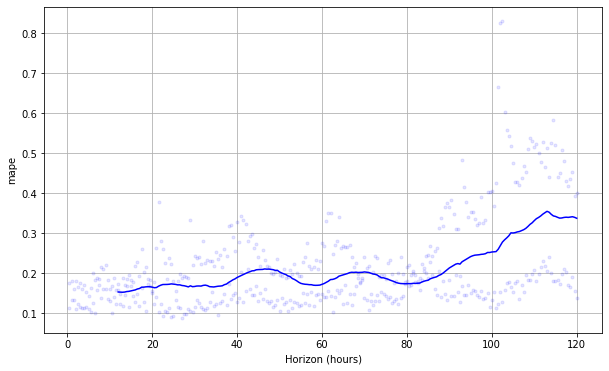

In [47]:
fig = plot_cross_validation_metric(df_cv, metric='mape')

### Hyperparameter Tunning

Para ajustar el modelo haremos uso de cross-validation con diferentes parametros, en busca del mejor resultado

In [35]:
param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
iteration = 0
for params in all_params:
    model = Prophet(**params).add_regressor('sentiment_v').add_regressor('sentiment_v2').fit(prophet_fit_df)
    df_cv = cross_validation(model, initial='2000 days', period='365 days', horizon = '5 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])
    iteration +=1 
    print(iteration)
    

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

INFO:prophet:Making 2 forecasts with cutoffs between 2020-06-04 23:30:00 and 2021-06-04 23:30:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001E3A7AAB280>


1


INFO:prophet:Making 2 forecasts with cutoffs between 2020-06-04 23:30:00 and 2021-06-04 23:30:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001E3A411EEE0>


2


INFO:prophet:Making 2 forecasts with cutoffs between 2020-06-04 23:30:00 and 2021-06-04 23:30:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001E3ABA89CD0>


3


INFO:prophet:Making 2 forecasts with cutoffs between 2020-06-04 23:30:00 and 2021-06-04 23:30:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001E41BDD2790>


4


INFO:prophet:Making 2 forecasts with cutoffs between 2020-06-04 23:30:00 and 2021-06-04 23:30:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001E3AB3E9D60>


5


INFO:prophet:Making 2 forecasts with cutoffs between 2020-06-04 23:30:00 and 2021-06-04 23:30:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001E3A7AB8430>


6


INFO:prophet:Making 2 forecasts with cutoffs between 2020-06-04 23:30:00 and 2021-06-04 23:30:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001E3A7A92790>


7


INFO:prophet:Making 2 forecasts with cutoffs between 2020-06-04 23:30:00 and 2021-06-04 23:30:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001E3AF827610>


8


INFO:prophet:Making 2 forecasts with cutoffs between 2020-06-04 23:30:00 and 2021-06-04 23:30:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001E3C870E7F0>


9


INFO:prophet:Making 2 forecasts with cutoffs between 2020-06-04 23:30:00 and 2021-06-04 23:30:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001E3ABA5BA60>


10


INFO:prophet:Making 2 forecasts with cutoffs between 2020-06-04 23:30:00 and 2021-06-04 23:30:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001E3A7AB4A30>


11


INFO:prophet:Making 2 forecasts with cutoffs between 2020-06-04 23:30:00 and 2021-06-04 23:30:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001E3ABAA8160>


12


INFO:prophet:Making 2 forecasts with cutoffs between 2020-06-04 23:30:00 and 2021-06-04 23:30:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001E3AF8297F0>


13


INFO:prophet:Making 2 forecasts with cutoffs between 2020-06-04 23:30:00 and 2021-06-04 23:30:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001E3A7A99490>


14


INFO:prophet:Making 2 forecasts with cutoffs between 2020-06-04 23:30:00 and 2021-06-04 23:30:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001E3AF817B80>


15


INFO:prophet:Making 2 forecasts with cutoffs between 2020-06-04 23:30:00 and 2021-06-04 23:30:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001E3A7A92880>


16
    changepoint_prior_scale  seasonality_prior_scale          rmse
0                     0.001                     0.01  11022.299073
1                     0.001                     0.10  11029.578119
2                     0.001                     1.00  11051.758347
3                     0.001                    10.00  11030.488405
4                     0.010                     0.01   8197.166040
5                     0.010                     0.10   8177.942684
6                     0.010                     1.00   8165.082052
7                     0.010                    10.00   8174.019334
8                     0.100                     0.01   7606.331425
9                     0.100                     0.10   7611.812724
10                    0.100                     1.00   7624.958951
11                    0.100                    10.00   7620.186823
12                    0.500                     0.01   7578.908048
13                    0.500                     0.10   7567

Tras un largo proceso de analisis podemos concluir que los mejores parametros para el modelos son:
* changepoint_prior_scale = 0.5
* seasonality_prior_scale = 1